## 1. 單獨做CNN 的部分

In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import os
import shutil
import pandas as pd
import datetime as dt


In [2]:
#抓取特定時間
stock_id = '3711.TW'
start = dt.datetime(2020,1,1)
end   = dt.datetime(2024, 10,10 )
data = yf.download(stock_id, start= start, end=end)

[*********************100%***********************]  1 of 1 completed


In [3]:
data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date']) ## 讓她是時間間數據。
data['Date'] = data['Date'].dt.strftime('%Y_%m_%d')
data = data.droplevel('Ticker', axis=1) # 刪除 `Ticker` 這層索引
data =data.drop(columns=['Adj Close'])  # 這是需要寫等於的。
data['Next_close'] = data['Close'].shift(-1) ## 將Close 欄位向上移動一行， 這樣'Next_Close' 會是下一天收盤價。
data['Diff'] = (data['Next_close'] > data['Close']).astype('int') ## 比較 'Next_Close' 和 'Close'，大於為1 ， 小於為0。 1代表漲的意識， 0 代表跌的意識。


In [4]:
## 準備劃K線圖的資料。
twenty_days = []
labels = []

for i in range(len(data.values) -20):
    segment = data[['Open','High','Low','Close']].values[i:i+20]
    twenty_days.append(segment)
    labels.append(data[['Date','Diff']].values[i+19]) #他要是到19 就有答案了。


In [5]:
#%% ## 我要去畫K  線圖。

image_path = './CNN_data/image'
os.makedirs(image_path, exist_ok=True)

for idx, segment in enumerate(twenty_days):
    #print(segment) ## 這個要在進去一次取才能取道 open，close ... 這些資料。
    fig, ax = plt.subplots() # 設置圖像大小（英寸）和 DPI
    fig.set_size_inches(0.5, 0.5)
    for day_idx ,day in enumerate(segment):
        Open_price, high_price , low_price, Close_price = map(int, day)
        color = "red" if Close_price > Open_price else "green"

        plt.bar(day_idx, abs(Close_price - Open_price), bottom=min(Open_price, Close_price), color=color, width=0.5)
        plt.bar(day_idx, high_price - low_price, bottom=low_price,color=color, width=0.1 )

    rise_or_fall = "rise" if labels[idx][1] ==1 else "fail"
    Datatime =  labels[idx][0]
    plt.axis('off')
    plt.savefig(f'{image_path}/{idx:05d}_{Datatime}_{rise_or_fall}.png', format='png',dpi=100)  ## 儲存圖片
    plt.close()


In [6]:
#%% Dataset Preparation
print('Dataset Preparation Start')
image_files = os.listdir(image_path)
train_size = int(len(image_files) * 0.8 )
train_list = image_files[:train_size]
test_list  = image_files[train_size: ]


train_rise_folder = './CNN_data/train_folder_path/rise'
train_fail_folder = './CNN_data/train_folder_path/fail'
test_rise_folder = './CNN_data/test_folder_path/rise'
test_fail_folder = './CNN_data/test_folder_path/fail'

for folder in [train_rise_folder, train_fail_folder, test_rise_folder, test_fail_folder]:
    os.makedirs(folder, exist_ok=True)


## 複製train 圖片到 train資料夾。
for train_image in train_list:
    scr_path = os.path.join('./CNN_data/image', train_image)
    #print(scr_path) ##./image\00368_2024_08_09_rise.png  多思，為什麼他是長這樣呀????
    rise_fail_str = str(scr_path).split('_')
    #print(rise_fail_str[4][0:4]) ## 取出 'rise' 或 false 字體
    #print(rise_fail_str)
    if rise_fail_str[5][0:4] == "rise" :
        dest_path = os.path.join(train_rise_folder+'/', train_image)
    if rise_fail_str[5][0:4] == "fail" :
        dest_path = os.path.join(train_fail_folder+'/', train_image)
    shutil.copy(scr_path, dest_path)

##複製test 圖片到 test 資料夾
for test_image in test_list:
    scr_path = os.path.join('./CNN_data/image', test_image)
    rise_fail_str = str(scr_path).split('_')
    if rise_fail_str[5][0:4] == "rise" :
        dest_path = os.path.join(test_rise_folder+'/', test_image)
    if rise_fail_str[5][0:4] == "fail" :
        dest_path = os.path.join(test_fail_folder+'/', test_image)
    shutil.copy(scr_path, dest_path)


Dataset Preparation Start


In [7]:
#%%  ## 接著我要建立CNN 模型
print("接著我要建立CNN 模型")
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#檢查GPU 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device) ## 顯示使用的裝置。

#定義轉換
transform = transforms.Compose([
    transforms.Resize((50, 50)),  ##調整圖片大小
    transforms.ToTensor()
])

#讀取訓練和驗證資料夾
train_data = datasets.ImageFolder(root='./CNN_data/train_folder_path/', transform= transform)
test_data = datasets.ImageFolder(root='./CNN_data/test_folder_path/', transform= transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

import torch.nn as nn
import matplotlib.pyplot as plt

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__() ## 要繼承他的爸爸

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size =3 , stride=1, padding=0), #(50 * 50) -> (48 * 48)
            nn.MaxPool2d(kernel_size=2, stride=2), # (48, 48) -> (24, 24)
            nn.ReLU(),

            nn.Conv2d(in_channels = 32, out_channels = 48, kernel_size = 3, stride=1, padding=0), #(24, 24) -> (22, 22)
            nn.MaxPool2d(kernel_size=2, stride=2), # (22, 22) -> (11, 11)
            nn.ReLU(),

            nn.Conv2d(in_channels = 48, out_channels = 64, kernel_size = 3, stride=1, padding=0),   #(11,11) -> (9,9)
            nn.MaxPool2d(kernel_size=2, stride=2), # (9,9) -> (4,4)
            nn.ReLU(),

            nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size =3, stride=1, padding=0),   #(4,4) -> (2,2)
            nn.MaxPool2d(kernel_size=2, stride=2),  #(2* 2) -> (1 * 1)
            nn.ReLU()
            )

        self.linear = nn.Sequential(
            nn.Linear(in_features= 96, out_features= 64),
            nn.Linear(in_features = 64, out_features = 32),
            nn.Linear(in_features= 32, out_features= 1),
            nn.Sigmoid()
            )
    def forward(self, x):
        out = self.cnn(x)
        cnn_out = out.view(out.size(0), -1)  #3 多思，我這樣攤平對嗎?
        linear_out = self.linear(cnn_out)

        return linear_out


接著我要建立CNN 模型
Using device:  cpu


In [8]:
import torch.optim as optim

model = CNN_Model()
print(model)

# 初始化模型並轉移至 GPU
model = CNN_Model().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_func = nn.BCELoss()
input_shape = (-1,3,50,50)  ##多思，這個要幹嘛?

# Traning the Model
#history-like list for store loss & acc value
training_loss_list = []
num_epochs = 50

# 開始訓練 訓練集
print("開始訓練 訓練集")
for epoch in range(num_epochs) :
    #print('epoch: ', epoch)
    model.train()
    running_loss = 0.0

    for i , (image, label) in enumerate(train_loader):
        images, labels = image.to(device), label.to(device) # 將 images 和 labels 轉移至 GPU
        #print(images.shape)
        #print(labels.shape)
        optimizer.zero_grad() # 2.Clear gradients  ## 清晰的漸變; 清理梯度
        #images = images.view(input_shape)

        outputs = model(images) # 3.Forward propagation ##前向傳播
        outputs = outputs.squeeze(-1)  # 移除最後一個維度 [16,1] -> [16] # 適用於 BCELoss 的輸出

        train_loss = loss_func(outputs, labels.float()) # 4.Calculate softmax and cross entropy loss  ## 計算softmax和交叉熵損失
        train_loss.backward()  # 5.Calculate gradients #計算梯度
        optimizer.step() # 6.Update parameters  ##更新參數
        running_loss += train_loss.item()

    # 計算訓練準確率
    avg_loss =  running_loss / len(train_loader)
    print(f"epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.7f} ")
    training_loss_list.append(avg_loss)

## 儲存模型
torch.save(model,'./CNN_data/CNN_model_test1.pt')

## 測試集
# 驗證模型

test_loss_lsit = []
test_accuracy = []
correct = 0
total = 0
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) # 將 images 和 labels 轉移至 GPU
        outputs = model(images)
        outputs = outputs.squeeze(-1)
        #計算損失
        loss = loss_func(outputs, labels.float())
        test_loss += loss.item()


        ## 計算準確率
        predicted = (outputs > 0.5).float()
        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels.float()).sum().item()
        #print(predicted, labels)

## 儲存測試損失準確度
avg_loss = test_loss/len(test_loader)
#print(f'Test Loss: {avg_loss:.4f}')
#print(len(test_loader))

test_loss_lsit.append(avg_loss)
accuracy_on_testData =  correct / total * 100
print(f'Accuracy on test data: {accuracy_on_testData:.2f}%')


CNN_Model(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=96, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
開始訓練 訓練集
epoch [1/50], Loss: 0.6939301 
epoch [2/50], Loss: 0.6934324 
epoch [3/50], Loss: 0.693630

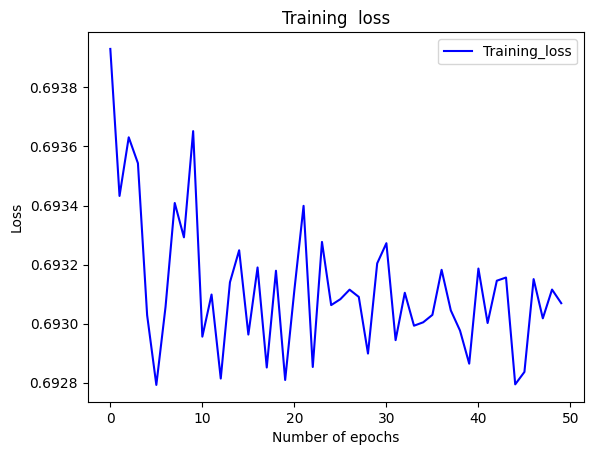

In [9]:
plt.plot(range(num_epochs), training_loss_list, 'b-', label='Training_loss')
plt.title('Training  loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.單獨做LSTM的話

In [10]:
!pip install ta

In [11]:
import numpy as np
import yfinance as yf
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
import datetime as dt

In [12]:
stock_id = '3711.TW'

#抓取特定時間
start = dt.datetime(2020,1,1)
end   = dt.datetime(2024, 10,10 )
data = yf.download(stock_id, start= start, end=end)

data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.strftime('%Y_%m_%d')

data = data.droplevel('Ticker', axis=1) # 刪除 `Ticker` 這層索引
data =data.drop(columns=['Adj Close'])  # 這是需要寫等於的。


# 加入目標變數 (Diff)
data['Next_close'] = data['Close'].shift(-1)
data['Diff'] = (data['Next_close'] > data['Close']).astype('int')
data = data.dropna()  # 確保沒有 NaN 資料

# 加入技術指標
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()

rsi = RSIIndicator(close=data['Close'], window=14)
data['RSI_14'] = rsi.rsi()

macd = MACD(close=data['Close'])
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()

bb = BollingerBands(close=data['Close'], window=20, window_dev=2)
data['BB_upper'] = bb.bollinger_hband()
data['BB_lower'] = bb.bollinger_lband()
data['BB_width'] = data['BB_upper'] - data['BB_lower']

data = data.dropna()

[*********************100%***********************]  1 of 1 completed


In [13]:
# 滑動窗口生成特徵和標籤
twenty_days = []
labels = []

for i in range(len(data.values) - 20):
    segment = data[['Open', 'High', 'Low', 'Close', 'Volume',
                    'SMA_5', 'SMA_20', 'RSI_14', 'MACD', 'BB_width']].values[i:i + 20]
    twenty_days.append(segment)
    labels.append(data['Diff'].values[i + 19])

# 分割訓練和測試集
train_size = int(len(labels) * 0.8)

train_x = np.array(twenty_days[:train_size], dtype=np.float32)
test_x = np.array(twenty_days[train_size:], dtype=np.float32)

train_y = np.array(labels[:train_size], dtype=np.float32)
test_y = np.array(labels[train_size:], dtype=np.float32)

# 轉換為 Torch 張量
train_x = torch.FloatTensor(train_x)
test_x = torch.FloatTensor(test_x)
train_y = torch.FloatTensor(train_y).view(-1)
test_y = torch.FloatTensor(test_y).view(-1)

# 建立 TensorDataset 和 DataLoader
batch_size = 64
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
# 定義 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size = 10, hidden_size = 64, num_layers=1, batch_first= True)
        self.Relu1 = nn.ReLU()
        self.lstm2 = nn.LSTM(input_size =64, hidden_size =32, num_layers=1, batch_first=True)
        self.Relu2 = nn.ReLU()

        self.fc = nn.Sequential(
            nn.Linear(in_features = 32 , out_features = 64),
            nn.Linear(in_features = 64, out_features = 32),
            nn.Linear(in_features = 32, out_features =1),
            nn.Sigmoid()
            )

    def forward(self, x):
        out, _ = self.lstm1(x)
        out    = self.Relu1(out)

        out, _ = self.lstm2(out)
        out    = self.Relu2(out)

        out = out[:, -1, :]  # 最後一個時間步
        out = self.fc(out)
        return out



In [15]:
# 超參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.BCELoss()

# 訓練和驗證
print("開始訓練")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        outputs = outputs.squeeze(-1)
        loss = loss_func(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            outputs = outputs.squeeze(-1)
            loss = loss_func(outputs, batch_y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


## 儲存模型
torch.save(model,'LSTM_model_test1.pt')


開始訓練
Epoch [1/100], Train Loss: 0.6931, Val Loss: 0.6928
Epoch [2/100], Train Loss: 0.6924, Val Loss: 0.6928
Epoch [3/100], Train Loss: 0.6930, Val Loss: 0.6931
Epoch [4/100], Train Loss: 0.6927, Val Loss: 0.6928
Epoch [5/100], Train Loss: 0.6926, Val Loss: 0.6928
Epoch [6/100], Train Loss: 0.6925, Val Loss: 0.6928
Epoch [7/100], Train Loss: 0.6929, Val Loss: 0.6928
Epoch [8/100], Train Loss: 0.6925, Val Loss: 0.6928
Epoch [9/100], Train Loss: 0.6927, Val Loss: 0.6928
Epoch [10/100], Train Loss: 0.6925, Val Loss: 0.6929
Epoch [11/100], Train Loss: 0.6927, Val Loss: 0.6928
Epoch [12/100], Train Loss: 0.6925, Val Loss: 0.6928
Epoch [13/100], Train Loss: 0.6928, Val Loss: 0.6929
Epoch [14/100], Train Loss: 0.6928, Val Loss: 0.6931
Epoch [15/100], Train Loss: 0.6926, Val Loss: 0.6928
Epoch [16/100], Train Loss: 0.6925, Val Loss: 0.6928
Epoch [17/100], Train Loss: 0.6927, Val Loss: 0.6928
Epoch [18/100], Train Loss: 0.6923, Val Loss: 0.6929
Epoch [19/100], Train Loss: 0.6926, Val Loss: 0.69

In [16]:
# 測試集結果評估
model.eval()
with torch.no_grad():
    test_preds = []
    for batch_x, _ in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        #print(outputs.squeeze(-1).cpu().numpy())
        test_preds.extend((outputs.squeeze(-1) > 0.5).cpu().numpy())

test_preds = np.array(test_preds)
accuracy = (test_preds == test_y.numpy()).mean()
print(f"測試集準確率: {accuracy:.2%}")

測試集準確率: 49.77%


In [17]:
#測試集結果評估 2
correct = 0
total = 0
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch_x, labels in test_loader:
        batch_x, labels = batch_x.to(device), labels.to(device) # 將 images 和 labels 轉移至 GPU
        outputs = model(batch_x)
        outputs = outputs.squeeze(-1)

        ##算準確率
        predicted = (outputs > 0.5).float()
        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels.float()).sum().item()

        #print(predicted, labels)

accuracy_on_testData =  correct / total * 100
print(f'Accuracy on test data: {accuracy_on_testData:.2f}%')


Accuracy on test data: 49.77%


## 3.使用LSTM與CNN進行特徵層融合

In [18]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import os
import shutil
import pandas as pd
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands

In [19]:
stock_id = '3711.TW'

#抓取特定時間
start = dt.datetime(2020,1,1)
end   = dt.datetime(2024, 10,10 )
data = yf.download(stock_id, start= start, end=end)

data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.strftime('%Y_%m_%d')

data = data.droplevel('Ticker', axis=1) # 刪除 `Ticker` 這層索引
data =data.drop(columns=['Adj Close'])  # 這是需要寫等於的。


# 加入目標變數 (Diff)
data['Next_close'] = data['Close'].shift(-1)
data['Diff'] = (data['Next_close'] > data['Close']).astype('int')
data = data.dropna()  # 確保沒有 NaN 資料

# 加入技術指標
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()

rsi = RSIIndicator(close=data['Close'], window=14)
data['RSI_14'] = rsi.rsi()

macd = MACD(close=data['Close'])
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()

bb = BollingerBands(close=data['Close'], window=20, window_dev=2)
data['BB_upper'] = bb.bollinger_hband()
data['BB_lower'] = bb.bollinger_lband()
data['BB_width'] = data['BB_upper'] - data['BB_lower']

data = data.dropna()

[*********************100%***********************]  1 of 1 completed


In [20]:
## 準備劃K線圖的資料。
twenty_days = []
labels = []

for i in range(len(data.values) -20):
    #segment = data[['Open','High','Low','Close']].values[i:i+20]
    segment = data[['Open', 'High', 'Low', 'Close', 'Volume',
                    'SMA_5', 'SMA_20', 'RSI_14', 'MACD', 'BB_width']].values[i:i + 20]

    twenty_days.append(segment)
    labels.append(data['Diff'].values[i+19]) #他要是到19 就有答案了。


In [21]:
# 分割訓練和測試集
train_size = int(len(labels) * 0.8)
train_x = np.array(twenty_days[:train_size], dtype=np.float32)
test_x = np.array(twenty_days[train_size:], dtype=np.float32)

train_y = np.array(labels[:train_size], dtype=np.float32)  ## 這裡是有時間的， 沒辦法直接這樣轉。
test_y = np.array(labels[train_size:], dtype=np.float32)


# 先處理 train_x
train_rise_folder = './CNN_LSTM_data/train_folder_path/rise'
train_fail_folder = './CNN_LSTM_data/train_folder_path/fail'
test_rise_folder = './CNN_LSTM_data/test_folder_path/rise'
test_fail_folder = './CNN_LSTM_data/test_folder_path/fail'


In [22]:
train_rise_folder = './CNN_LSTM_data/train_folder_path/rise'
train_fail_folder = './CNN_LSTM_data/train_folder_path/fail'
test_rise_folder = './CNN_LSTM_data/test_folder_path/rise'
test_fail_folder = './CNN_LSTM_data/test_folder_path/fail'

for folder in [train_rise_folder, train_fail_folder, test_rise_folder, test_fail_folder]:
    os.makedirs(folder, exist_ok=True)

for idx, segment in enumerate(train_x):
    #plt.figure(figsize=(1,1))
    # 創建圖像
    fig, ax = plt.subplots() # 設置圖像大小（英寸）和 DPI
    fig.set_size_inches(0.5, 0.5)
    for day_idx ,day in enumerate(segment):

        Open_price, high_price , low_price, Close_price = map(int, day[0:4])
        color = "red" if Close_price > Open_price else "green"

        plt.bar(day_idx, abs(Close_price - Open_price), bottom=min(Open_price, Close_price), color=color, width=0.5)
        plt.bar(day_idx, high_price - low_price, bottom=low_price,color=color, width=0.1 )

    rise_or_fall = "rise" if train_y[idx] ==1 else "fail"
    plt.axis('off')
    if rise_or_fall == 'rise':
        plt.savefig(f'{train_rise_folder}/{idx:05d}_{rise_or_fall}.png', format='png',dpi=100)  ## 儲存圖片
    else:
        plt.savefig(f'{train_fail_folder}/{idx:05d}_{rise_or_fall}.png', format='png',dpi=100)  ## 儲存圖片
    plt.close()

In [23]:
for idx, segment in enumerate(test_x):
    fig, ax = plt.subplots() # 設置圖像大小（英寸）和 DPI
    fig.set_size_inches(0.5, 0.5)
    for day_idx ,day in enumerate(segment):
        Open_price, high_price , low_price, Close_price = map(int, day[0:4])
        color = "red" if Close_price > Open_price else "green"

        plt.bar(day_idx, abs(Close_price - Open_price), bottom=min(Open_price, Close_price), color=color, width=0.5)
        plt.bar(day_idx, high_price - low_price, bottom=low_price,color=color, width=0.1 )

    rise_or_fall = "rise" if test_y[idx] ==1 else "fail"
    plt.axis('off')
    if rise_or_fall == 'rise':
        plt.savefig(f'{test_rise_folder}/{(len(train_x)+idx):05d}_{rise_or_fall}.png', format='png',dpi=100)  ## 儲存圖片
    else:
        plt.savefig(f'{test_fail_folder}/{(len(train_x)+idx):05d}_{rise_or_fall}.png', format='png',dpi=100)  ## 儲存圖片
    plt.close()

In [24]:
import torch
from torchvision import datasets, transforms
# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
    ])

class FusionDataset(torch.utils.data.Dataset):
    def __init__(self, lstm_data, lstm_labels, image_folder, transform=None):
        self.lstm_data = lstm_data
        self.lstm_labels = lstm_labels
        self.image_data = datasets.ImageFolder(root=image_folder, transform= transform)

    def __len__(self):
        return len(self.lstm_data)

    def __getitem__(self, idx):   ## 多思，如果他這樣寫，是什麼時候會需要被呼叫使用。
        lstm_data = self.lstm_data[idx]
        lstm_label = self.lstm_labels[idx]
        cnn_image, cnn_label = self.image_data[idx]
        return torch.FloatTensor(lstm_data), cnn_image, lstm_label

CNN_train_path = './CNN_LSTM_data/train_folder_path/'
CNN_test_path  = './CNN_LSTM_data/test_folder_path/'
train_dataset = FusionDataset(lstm_data = train_x, lstm_labels = train_y, image_folder = CNN_train_path, transform= transform)
test_dataset = FusionDataset(lstm_data = test_x, lstm_labels = test_y, image_folder = CNN_test_path, transform= transform)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle = True)
test_loader  = DataLoader(test_dataset , batch_size=16, shuffle= False)


In [25]:
#%% # 定義模型。 Fusion Model Definition
import torch.nn as nn
class FusionModel(nn.Module):
    def __init__(self, lstm_input_size, cnn_input_shape):  ##多思， 它這裡只是先做定義而已。
        super(FusionModel, self).__init__()
        self.lstm = nn.LSTM(input_size = lstm_input_size, hidden_size = 64, num_layers=2 , batch_first=True)
        self.lstm_fc = nn.Linear(in_features = 64, out_features = 32)

        self.cnn = nn.Sequential(   ## 多思， 他這邊就用 Sequential 去做。  #自己要知道 Sequential 是要有逗號的。
            nn.Conv2d(in_channels= 3 , out_channels=32, kernel_size=3, stride=1, padding=0),    #(50* 50)  -> (48 * 48)
            nn.MaxPool2d(kernel_size=2, stride=2), ## (48, 48) -> (24,24)
            nn.ReLU(),

            nn.Conv2d(in_channels = 32, out_channels = 48, kernel_size = 3, stride=1, padding=0), #(24, 24) -> (22, 22)
            nn.MaxPool2d(kernel_size=2, stride=2) , # (22, 22)  -> (11, 11)
            nn.ReLU(),

            nn.Conv2d(in_channels = 48, out_channels = 64, kernel_size = 3, stride=1, padding=0),  ## (11,11) -> (9, 9)
            nn.MaxPool2d(kernel_size=2, stride=2),  #(9,9)  => (4,4)
            nn.ReLU(),

            nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3, stride=1, padding=0), ## (4*4 ) -> (2* 2)
            nn.MaxPool2d(kernel_size=2, stride=2),  # (2* 2) -> (1* 1)
            nn.ReLU(),

            )
        self.FusionPart = nn.Sequential(
            nn.Linear(in_features = 32 + 96 , out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256 , out_features =32),
            nn.ReLU(),
            nn.Linear(in_features= 32, out_features = 1),
            nn.Sigmoid()
            )

    def  forward(self, time_data, image_data):
        lstm_out, _ = self.lstm(time_data)
        lstm_feature = self.lstm_fc(lstm_out[:,-1, :]) #32

        cnn_out = self.cnn(image_data)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) ##我要把它做攤平。 96

        fused_feature = torch.cat((lstm_feature, cnn_out), dim=1)
        fused_feature = self.FusionPart(fused_feature)

        return fused_feature


In [26]:
#%%  ## 我要去做訓練的動作了。
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FusionModel(lstm_input_size = 10 , cnn_input_shape =(3, 50, 50) ).to(device)
loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0  ##多思， 他這樣也有要計算correct 的想法。

    for lstm_data, cnn_data, labels in train_loader: #多思，我們看這個， 它是可以一次全部的喔!!， 讚讚。
        lstm_data, cnn_data, labels = lstm_data.to(device), cnn_data.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(lstm_data, cnn_data)
        output = output.squeeze(-1)
        loss  = loss_func(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()    ## 多思， 這個loss 要去除嗎? 它怎麼沒有這樣去做???
        predicted = (output > 0.5).float()  ## 多思，這是要去做它輸出的結果。
        correct += (predicted == labels).sum().item()
        total += labels.size(0)  ## 多思， 這算總和的方式是這樣去算的。

    accuracy = correct / total
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch [1/50], Loss: 0.6932, Accuracy: 0.5187
Epoch [2/50], Loss: 0.6927, Accuracy: 0.5187
Epoch [3/50], Loss: 0.6927, Accuracy: 0.5187
Epoch [4/50], Loss: 0.6933, Accuracy: 0.5187
Epoch [5/50], Loss: 0.6932, Accuracy: 0.5187
Epoch [6/50], Loss: 0.6927, Accuracy: 0.5187
Epoch [7/50], Loss: 0.6931, Accuracy: 0.5187
Epoch [8/50], Loss: 0.6931, Accuracy: 0.5187
Epoch [9/50], Loss: 0.6924, Accuracy: 0.5187
Epoch [10/50], Loss: 0.6929, Accuracy: 0.5187
Epoch [11/50], Loss: 0.6929, Accuracy: 0.5187
Epoch [12/50], Loss: 0.6927, Accuracy: 0.5187
Epoch [13/50], Loss: 0.6923, Accuracy: 0.5187
Epoch [14/50], Loss: 0.6924, Accuracy: 0.5187
Epoch [15/50], Loss: 0.6913, Accuracy: 0.5187
Epoch [16/50], Loss: 0.6914, Accuracy: 0.5187
Epoch [17/50], Loss: 0.6916, Accuracy: 0.5187
Epoch [18/50], Loss: 0.6915, Accuracy: 0.5187
Epoch [19/50], Loss: 0.6915, Accuracy: 0.5187
Epoch [20/50], Loss: 0.6913, Accuracy: 0.5187
Epoch [21/50], Loss: 0.6910, Accuracy: 0.5187
Epoch [22/50], Loss: 0.6914, Accuracy: 0.51

In [27]:
#%%   ## 進行評估。

model.eval()
correct, total = 0, 0

with torch.no_grad():
    for lstm_data, cnn_data, labels in test_loader:
        lstm_data, cnn_data, labels = lstm_data.to(device), cnn_data.to(device), labels.to(device)

        output = model(lstm_data, cnn_data)
        output = output.squeeze(-1)
        predicted = (output > 0.5).float()

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct /total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5023


## 4.CNN+LSTM 決策層融合

In [28]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import os
import shutil
import pandas as pd

from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
import datetime as dt

In [29]:
stock_id = '3711.TW'

#抓取特定時間
start = dt.datetime(2020,1,1)
end   = dt.datetime(2024, 10,10 )
data = yf.download(stock_id, start= start, end=end)

data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date']) ## 讓她是時間間數據。
data['Date'] = data['Date'].dt.strftime('%Y_%m_%d')

data = data.droplevel('Ticker', axis=1) # 刪除 `Ticker` 這層索引
data =data.drop(columns=['Adj Close'])  # 這是需要寫等於的。

# 加入目標變數。
data['Next_close'] = data['Close'].shift(-1) ## 將Close 欄位向上移動一行， 這樣'Next_Close' 會是下一天收盤價。
data['Diff'] = (data['Next_close'] > data['Close']).astype('int') ## 比較 'Next_Close' 和 'Close'，大於為1 ， 小於為0。 1代表漲的意識， 0 代表跌的意識。
#print(data.head(5))


# 加入技術指標。
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()

rsi = RSIIndicator(close=data['Close'], window=14)
data['RSI_14'] = rsi.rsi()

macd = MACD(close=data['Close'])
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()

bb = BollingerBands(close=data['Close'], window=20, window_dev=2)
data['BB_upper'] = bb.bollinger_hband()
data['BB_lower'] = bb.bollinger_lband()
data['BB_width'] = data['BB_upper'] - data['BB_lower']
data = data.dropna()


[*********************100%***********************]  1 of 1 completed


In [30]:
## 準備劃K線圖的資料。
twenty_days = []
labels = []

for i in range(len(data.values) -20):
    #segment = data[['Open','High','Low','Close']].values[i:i+20]
    segment = data[['Open', 'High', 'Low', 'Close', 'Volume',
                    'SMA_5', 'SMA_20', 'RSI_14', 'MACD', 'BB_width']].values[i:i + 20]

    twenty_days.append(segment)
    labels.append(data['Diff'].values[i+19]) #他要是到19 就有答案了。

In [31]:
# 分割訓練和測試集
train_size = int(len(labels) * 0.8)
train_x = np.array(twenty_days[:train_size], dtype=np.float32)
test_x = np.array(twenty_days[train_size:], dtype=np.float32)

train_y = np.array(labels[:train_size], dtype=np.float32)  ## 這裡是有時間的， 沒辦法直接這樣轉。
test_y = np.array(labels[train_size:], dtype=np.float32)


In [32]:
train_rise_folder = './late_CNN_LSTM_data/train_folder_path/rise'
train_fail_folder = './late_CNN_LSTM_data/train_folder_path/fail'
test_rise_folder = './late_CNN_LSTM_data/test_folder_path/rise'
test_fail_folder = './late_CNN_LSTM_data/test_folder_path/fail'

for folder in [train_rise_folder, train_fail_folder, test_rise_folder, test_fail_folder]:
    os.makedirs(folder, exist_ok=True)

In [33]:
for idx, segment in enumerate(train_x):
    # 創建圖像
    fig, ax = plt.subplots() # 設置圖像大小（英寸）和 DPI
    fig.set_size_inches(0.5, 0.5)
    for day_idx ,day in enumerate(segment):


        Open_price, high_price , low_price, Close_price = map(int, day[0:4])
        color = "red" if Close_price > Open_price else "green"

        plt.bar(day_idx, abs(Close_price - Open_price), bottom=min(Open_price, Close_price), color=color, width=0.5)
        plt.bar(day_idx, high_price - low_price, bottom=low_price,color=color, width=0.1 )

    rise_or_fall = "rise" if train_y[idx] ==1 else "fail"
    plt.axis('off')
    if rise_or_fall == 'rise':
        plt.savefig(f'{train_rise_folder}/{idx:05d}_{rise_or_fall}.png', format='png',dpi=100)  ## 儲存圖片
    else:
        plt.savefig(f'{train_fail_folder}/{idx:05d}_{rise_or_fall}.png', format='png',dpi=100)  ## 儲存圖片
    plt.close()


In [34]:
for idx, segment in enumerate(test_x):
    fig, ax = plt.subplots() # 設置圖像大小（英寸）和 DPI
    fig.set_size_inches(0.5, 0.5)
    for day_idx ,day in enumerate(segment):
        Open_price, high_price , low_price, Close_price = map(int, day[0:4])
        color = "red" if Close_price > Open_price else "green"

        plt.bar(day_idx, abs(Close_price - Open_price), bottom=min(Open_price, Close_price), color=color, width=0.5)
        plt.bar(day_idx, high_price - low_price, bottom=low_price,color=color, width=0.1 )

    rise_or_fall = "rise" if test_y[idx] ==1 else "fail"
    plt.axis('off')
    if rise_or_fall == 'rise':
        plt.savefig(f'{test_rise_folder}/{(len(train_x)+idx):05d}_{rise_or_fall}.png', format='png',dpi=100)  ## 儲存圖片
    else:
        plt.savefig(f'{test_fail_folder}/{(len(train_x)+idx):05d}_{rise_or_fall}.png', format='png',dpi=100)  ## 儲存圖片
    plt.close()

In [35]:
import torch
from torchvision import datasets, transforms
# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
    ])

class FusionDataset(torch.utils.data.Dataset):
    def __init__(self, lstm_data, lstm_labels, image_folder, transform=None):
        self.lstm_data = lstm_data
        self.lstm_labels = lstm_labels
        self.image_data = datasets.ImageFolder(root=image_folder, transform= transform)

    def __len__(self):
        return len(self.lstm_data)

    def __getitem__(self, idx):   ## 多思，如果他這樣寫，是什麼時候會需要被呼叫使用。
        lstm_data = self.lstm_data[idx]
        lstm_label = self.lstm_labels[idx]
        cnn_image, cnn_label = self.image_data[idx]
        return torch.FloatTensor(lstm_data), cnn_image, lstm_label

CNN_train_path = './late_CNN_LSTM_data/train_folder_path/'
CNN_test_path  = './late_CNN_LSTM_data/test_folder_path/'
train_dataset = FusionDataset(lstm_data = train_x, lstm_labels = train_y, image_folder = CNN_train_path, transform= transform)
test_dataset = FusionDataset(lstm_data = test_x, lstm_labels = test_y, image_folder = CNN_test_path, transform= transform)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle = True)
test_loader  = DataLoader(test_dataset , batch_size=16, shuffle= False)


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [37]:
#%% 定義模型結構
class MLP_FusionModel(nn.Module):
    def __init__(self):
        super(MLP_FusionModel, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=4),
            nn.ReLU(),
            nn.Linear(in_features=4, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, LSTM_value, CNN_value):
        fused_feature = torch.cat((LSTM_value, CNN_value), dim=1)
        out = self.linear(fused_feature)
        return out


class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.linear = nn.Sequential(
            nn.Linear(in_features=96, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.cnn(x)
        cnn_out = out.view(out.size(0), -1)  # 攤平處理
        linear_out = self.linear(cnn_out)
        return linear_out


class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=10, hidden_size=64, num_layers=1, batch_first=True)
        self.relu1 = nn.ReLU()
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
        self.relu2 = nn.ReLU()
        self.fc = nn.Sequential(
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.relu1(out)
        out, _ = self.lstm2(out)
        out = self.relu2(out)
        out = out[:, -1, :]  # 取最後一個時間步
        out = self.fc(out)
        return out



In [38]:
#%% 設定設備與載入模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CNN_model = CNN_Model().to(device)
LSTM_model = LSTMModel().to(device)
MLP_model = MLP_FusionModel().to(device)

In [39]:
#%% 設定訓練與驗證函數
def train_epoch(train_loader, models, optimizer, loss_func, device):
    CNN_model, LSTM_model, MLP_model = models
    CNN_model.train()
    LSTM_model.train()
    MLP_model.train()
    total_loss, correct, total = 0, 0, 0

    for lstm_data, cnn_data, labels in train_loader:
        lstm_data, cnn_data, labels = lstm_data.to(device), cnn_data.to(device), labels.to(device)
        optimizer.zero_grad()

        lstm_value = LSTM_model(lstm_data)
        cnn_value = CNN_model(cnn_data)
        output = MLP_model(lstm_value, cnn_value).squeeze(-1)

        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (output > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(train_loader), correct / total


def evaluate(val_loader, models, loss_func, device):
    CNN_model, LSTM_model, MLP_model = models
    CNN_model.eval()
    LSTM_model.eval()
    MLP_model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for lstm_data, cnn_data, labels in val_loader:
            lstm_data, cnn_data, labels = lstm_data.to(device), cnn_data.to(device), labels.to(device)
            lstm_value = LSTM_model(lstm_data)
            cnn_value = CNN_model(cnn_data)
            output = MLP_model(lstm_value, cnn_value).squeeze(-1)

            loss = loss_func(output, labels)
            total_loss += loss.item()
            predicted = (output > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(val_loader), correct / total

In [40]:
#%% 訓練流程
loss_func = nn.BCELoss()
optimizer = optim.Adam(MLP_model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(train_loader, (CNN_model, LSTM_model, MLP_model), optimizer, loss_func, device)
    val_loss, val_acc = evaluate(test_loader, (CNN_model, LSTM_model, MLP_model), loss_func, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")



Epoch [1/50]
Train Loss: 0.6932, Train Accuracy: 0.5187
Validation Loss: 0.6965, Validation Accuracy: 0.5023
Epoch [2/50]
Train Loss: 0.6926, Train Accuracy: 0.5187
Validation Loss: 0.6958, Validation Accuracy: 0.5023
Epoch [3/50]
Train Loss: 0.6937, Train Accuracy: 0.5187
Validation Loss: 0.6953, Validation Accuracy: 0.5023
Epoch [4/50]
Train Loss: 0.6939, Train Accuracy: 0.5187
Validation Loss: 0.6948, Validation Accuracy: 0.5023
Epoch [5/50]
Train Loss: 0.6932, Train Accuracy: 0.5187
Validation Loss: 0.6943, Validation Accuracy: 0.5023
Epoch [6/50]
Train Loss: 0.6919, Train Accuracy: 0.5187
Validation Loss: 0.6940, Validation Accuracy: 0.5023
Epoch [7/50]
Train Loss: 0.6924, Train Accuracy: 0.5187
Validation Loss: 0.6940, Validation Accuracy: 0.5023
Epoch [8/50]
Train Loss: 0.6933, Train Accuracy: 0.5187
Validation Loss: 0.6939, Validation Accuracy: 0.5023
Epoch [9/50]
Train Loss: 0.6927, Train Accuracy: 0.5187
Validation Loss: 0.6937, Validation Accuracy: 0.5023
Epoch [10/50]
Train